In [67]:
google_colab_flag = True

In [68]:
from google.colab import drive
import sys

In [69]:
if(google_colab_flag):

  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/Eye-Diseases-Data/DR-GL/'
  sys.path.append(root_path)

else:
  root_path = ''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score 
from sklearn.model_selection import StratifiedKFold
from PIL import Image
from glob import glob
import random
import keras
import tensorflow as tf
from tensorflow import keras
import warnings
import os
import shutil
from PIL import ImageFile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D

In [71]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2 as cv
import os

In [72]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [73]:
warnings.simplefilter('error', Image.DecompressionBombWarning)
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [74]:
Image.MAX_IMAGE_PIXELS = 1000000000
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [75]:
dataset_folder_name = root_path + 'Dataset'

model_file_name = root_path + 'model_cv.h5'

In [76]:
source_files = []
class_labels = ['diabetic-retinopathy', 'glaucoma']

X = []
Y = []

In [77]:
image_rows, image_cols = 200, 200

train_path = dataset_folder_name + '/train/'
validation_path = dataset_folder_name + '/validation/'
test_path = dataset_folder_name + '/test/'

In [78]:
def transferBetweenFolders(source, dest, splitRate):

  global source_files
  source_files = os.listdir(source)

  if(len(source_files) != 0):

    transfer_file_numbers = int(len(source_files) * splitRate)
    transfer_index = random.sample(range(0, len(source_files)), transfer_file_numbers)

    for each_index in transfer_index:

      shutil.move(source + str(source_files[each_index]), dest + str(source_files[each_index]))

  else:
    
   print("No file moved. Source empty!")

In [79]:
def transferAllClassBetweenFolders(source, dest, splitRate):

  for label in class_labels:

    transferBetweenFolders(dataset_folder_name + '/' + source + '/' + label + '/',
                                   dataset_folder_name + '/' + dest + '/' + label + '/',
                                   splitRate)

In [80]:
def my_metrics(y_true, y_pred):

  confusionMatrix = confusion_matrix(y_true, y_pred)
  print(confusionMatrix)

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average= 'weighted')
  sensitivity = confusionMatrix[0, 0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
  specificity = confusionMatrix[1,1]/(confusionMatrix[1,0] + confusionMatrix[1,1])
  f1Score = f1_score(y_true, y_pred, average= 'weighted')


  print("Accuracy  : {}".format(accuracy))
  print("Precision : {}".format(precision))
  print("Sensitivity: {}".format(sensitivity))
  print("specificity: {}".format(specificity))
  print("f1Score : {}".format(f1Score))

  return accuracy, precision, f1Score

In [81]:
transferAllClassBetweenFolders('test', 'train', 1.0)

In [82]:
transferAllClassBetweenFolders('train', 'test', 0.2)

In [83]:
def prepareNameWithLabels(folder_name):

    source_files = os.listdir(dataset_folder_name +'/train/'+ folder_name)
    for val in source_files:
      
        X.append(val)
        for i in range(len(class_labels)):
          if(folder_name == class_labels[i]):
              Y.append(i)

In [84]:
# Organize file names and class labels in X and Y variables

for i in range(len(class_labels)):
  
  prepareNameWithLabels(class_labels[i])

In [85]:
X = np.asarray(X)
Y = np.asarray(Y)

In [86]:
batch_size = 8
epoch = 3

In [87]:
model1 = Sequential()

# 1st layers
model1.add(Conv2D(filters= 16, kernel_size= 3, activation= 'relu', input_shape=(image_rows, image_cols, 3)))
model1.add(Conv2D(filters= 16, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

# 2nd layers
model1.add(Conv2D(filters= 32, kernel_size= 3, activation= 'relu'))
model1.add(Conv2D(filters= 32, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

# 3rd layers
model1.add(Conv2D(filters= 64, kernel_size= 3, activation= 'relu'))
model1.add(Conv2D(filters= 64, kernel_size= 3, activation= 'relu'))
model1.add(MaxPool2D(2, 2))

model1.add(Flatten())

model1.add(Dense(512, activation= 'relu'))
model1.add(Dense(len(class_labels), activation= 'sigmoid'))

In [88]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 conv2d_13 (Conv2D)          (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 98, 98, 16)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 96, 96, 32)        4640      
                                                                 
 conv2d_15 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                  

In [90]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
skf.get_n_splits(X, Y)

foldNum=0

In [91]:
for train_index, val_index in skf.split(X, Y):

  transferAllClassBetweenFolders('validation', 'train', 1.0)

  foldNum += 1
  print("Fold Result: ", foldNum)

  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = Y[train_index], Y[val_index]

  for each_index in range(len(X_val)):

    class_label = ''
    for i in range(len(class_labels)):

      if(Y_val[each_index] == i):
        class_label = class_labels[i]

    shutil.move(dataset_folder_name + '/train/' + class_label + '/' + X_val[each_index],
                dataset_folder_name + '/validation/' + class_label + '/' + X_val[each_index])
  
  train_datagen = ImageDataGenerator(
                      rescale = 1./255,
                      zoom_range = 0.20,
                      fill_mode = "nearest")
  
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  test_datagen = ImageDataGenerator(rescale = 1./255)

  #Start ImageClassification Model
  train_generator = train_datagen.flow_from_directory(
      
      train_path,
      target_size = (image_rows, image_cols),
      batch_size = batch_size,
      class_mode = 'categorical',
      subset = 'training')

  validation_generator = validation_datagen.flow_from_directory(
      
      validation_path,
      target_size = (image_rows, image_cols),
      batch_size = batch_size,
      class_mode = None,  # only data, no labels
      shuffle = False)
  
  # fit model

  history = model1.fit_generator(train_generator, 
                        epochs = epoch,
                        )
    
  predictions = model1.predict_generator(validation_generator, verbose=1)
  yPredictions = np.argmax(predictions, axis=1)
  true_classes = validation_generator.classes

  # evaluate validation performance

  print("***Performance on Validation data***")    
  valAcc, valPrec, valFScore = my_metrics(true_classes, yPredictions)

No file moved. Source empty!
Fold Result:  1
Found 2717 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
340/340 [==============================] - 342s 1s/step - loss: 0.3761 - accuracy: 0.8399
Epoch 2/3
340/340 [==============================] - 338s 993ms/step - loss: 0.2694 - accuracy: 0.8767
Epoch 3/3
340/340 [==============================] - 337s 992ms/step - loss: 0.2456 - accuracy: 0.9036


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


76/76 [==============================] - 29s 385ms/step
***Performance on Validation data***
[[434   9]
 [ 25 134]]
Accuracy  : 0.9435215946843853
Precision : 0.9432964562923524
Sensitivity: 0.9796839729119639
specificity: 0.8427672955974843
f1Score : 0.9425263951075988
Fold Result:  2
Found 2717 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
340/340 [==============================] - 339s 995ms/step - loss: 0.1697 - accuracy: 0.9308
Epoch 2/3
340/340 [==============================] - 337s 991ms/step - loss: 0.1547 - accuracy: 0.9411
Epoch 3/3
340/340 [==============================] - 338s 992ms/step - loss: 0.0965 - accuracy: 0.9643


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


76/76 [==============================] - 29s 376ms/step
***Performance on Validation data***
[[433  10]
 [ 16 143]]
Accuracy  : 0.9568106312292359
Precision : 0.956514371429413
Sensitivity: 0.9774266365688488
specificity: 0.89937106918239
f1Score : 0.9565406045617747
Fold Result:  3
Found 2717 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
340/340 [==============================] - 341s 1s/step - loss: 0.0732 - accuracy: 0.9735
Epoch 2/3
340/340 [==============================] - 336s 987ms/step - loss: 0.0752 - accuracy: 0.9768
Epoch 3/3
340/340 [==============================] - 336s 988ms/step - loss: 0.0548 - accuracy: 0.9831


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


76/76 [==============================] - 29s 387ms/step
***Performance on Validation data***
[[434   9]
 [  1 158]]
Accuracy  : 0.9833887043189369
Precision : 0.9840743304318159
Sensitivity: 0.9796839729119639
specificity: 0.9937106918238994
f1Score : 0.9835168460131939
Fold Result:  4
Found 2717 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
340/340 [==============================] - 338s 994ms/step - loss: 0.0614 - accuracy: 0.9798
Epoch 2/3
340/340 [==============================] - 335s 985ms/step - loss: 0.0441 - accuracy: 0.9860
Epoch 3/3
340/340 [==============================] - 334s 983ms/step - loss: 0.0348 - accuracy: 0.9879


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


76/76 [==============================] - 28s 369ms/step
***Performance on Validation data***
[[442   1]
 [  1 158]]
Accuracy  : 0.9966777408637874
Precision : 0.9966777408637874
Sensitivity: 0.9977426636568849
specificity: 0.9937106918238994
f1Score : 0.9966777408637874
Fold Result:  5
Found 2717 images belonging to 2 classes.
Found 602 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/3
340/340 [==============================] - 337s 991ms/step - loss: 0.0399 - accuracy: 0.9875
Epoch 2/3
340/340 [==============================] - 335s 983ms/step - loss: 0.0254 - accuracy: 0.9930
Epoch 3/3
340/340 [==============================] - 334s 983ms/step - loss: 0.0372 - accuracy: 0.9890


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


76/76 [==============================] - 28s 369ms/step
***Performance on Validation data***
[[438   4]
 [  0 160]]
Accuracy  : 0.9933554817275747
Precision : 0.9935175431488534
Sensitivity: 0.9909502262443439
specificity: 1.0
f1Score : 0.9933813960945744


In [92]:
print('=============== Test Result ==============')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size = (image_rows, image_cols),
                                                  batch_size = batch_size,
                                                  class_mode = None,
                                                  shuffle = False)

predictions = model1.predict(test_generator, verbose = 1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

testAcc,testPrec, testFScore = my_metrics(true_classes, yPredictions)
model1.save(model_file_name)

=============== Test Result ==============
Found 751 images belonging to 2 classes.
94/94 [==============================] - 36s 383ms/step
[[549   4]
 [  2 196]]
Accuracy  : 0.9920106524633822
Precision : 0.9920542482980949
Sensitivity: 0.9927667269439421
specificity: 0.98989898989899
f1Score : 0.9920234894730701


In [93]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [94]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [95]:
# predict probabilities
pred_prob1 = model1.predict(test_generator)

In [96]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(yPredictions, pred_prob1[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(yPredictions))]
p_fpr, p_tpr, _ = roc_curve(yPredictions, random_probs, pos_label=1)

In [97]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(yPredictions, pred_prob1[:,1])

print("Area Under Curve: ", auc_score1)

Area Under Curve:  1.0


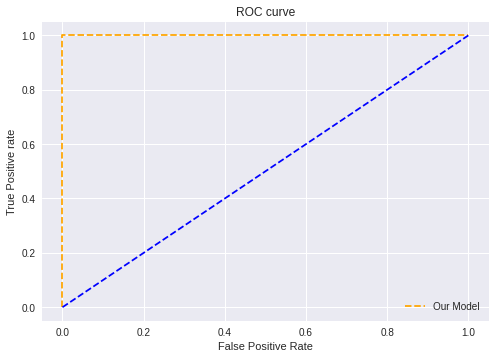

In [98]:
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Our Model')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();